In [1]:
from collections import defaultdict
from cycler import cycler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import wandb

In [2]:
experiment_name = "v3_r40u20"  # TODO: replace with yours
wandb_entity = "sita"  # TODO: replace with yours
wandb_project = "source-reliability"  

In [3]:
api = wandb.Api()

# 1. Pull wandb runs from a specific organization and project
runs = api.runs(f'{wandb_entity}/{wandb_project}')

# 2. Filter the runs
filtered_runs = [run for run in runs if run.config.get('experiment_name') == experiment_name and run.state not in ["crashed", "failed"]]

# 3. Group the runs by run.config.data_path
runs_by_path = defaultdict(list)
for run in filtered_runs:
    data_path = run.config.get('data_path')
    if data_path:
        runs_by_path[data_path].append(run)

print(f'Found {len(runs_by_path)} groups of runs:')
for data_path, runs in runs_by_path.items():
    print(f'{data_path}: {len(runs)} runs')



Found 4 groups of runs:
v3_r40u20: 12 runs
v3_r40u20_09: 12 runs
v3_r40u20_075: 12 runs
v3_r40u20_05: 12 runs


In [4]:
def get_reliability_from_datapath(data_path: str) -> int:
    sep = "_0"
    if sep not in data_path:
        reliability = 100
    else:
        reliability = data_path.split(sep)[1]
        reliability = reliability.ljust(2, '0')
    return int(reliability)

### Frequency of most reliable

In [5]:
# 4. Make data for the plot
plot_data = []
for data_path, runs in runs_by_path.items():

    # Collect epoch and accuracy data across runs for the same data path
    accuracies_by_epoch = defaultdict(list)
    for run in runs:
        num_epochs = run.config.get('num_epochs')
        metric_key = 'eval/mean/fraction_reliable'

        if metric_key not in run.summary:
            continue

        history = run.scan_history(keys=[metric_key])
        for i, row in enumerate(history):
            epoch_num = i+1 # assume logged once per epoch
            accuracies_by_epoch[epoch_num].append(row[metric_key])

        assert len(accuracies_by_epoch) == num_epochs, f"num_epochs: {num_epochs}, len(accuracies_by_epoch): {len(accuracies_by_epoch)}"

    # Convert to numpy arrays for easier manipulation
    epochs = np.array(list(accuracies_by_epoch.keys()))
    accuracies = np.array(list(accuracies_by_epoch.values()))

    # Calculate mean and standard deviation
    mean_accuracy = np.mean(accuracies, axis=1)
    std_accuracy = np.std(accuracies, axis=1)

    # Plot mean accuracy and standard deviation
    plot_data.append((data_path, epochs, mean_accuracy, std_accuracy))

plot_data.sort(key=lambda x: get_reliability_from_datapath(x[0]), reverse=True)

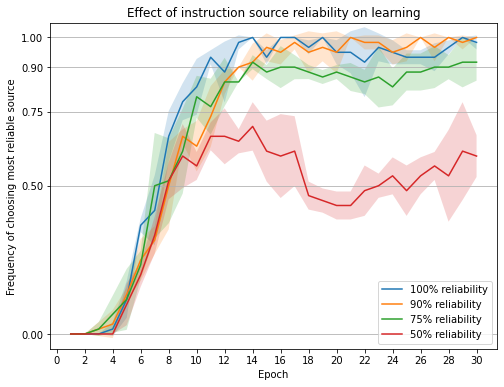

In [7]:
for data_path, epochs, mean_accuracy, std_accuracy in plot_data:
    reliability = get_reliability_from_datapath(data_path)
    label = f"{reliability}% reliability"

    plt.plot(epochs, mean_accuracy, label=label)
    plt.fill_between(epochs, mean_accuracy-std_accuracy, mean_accuracy+std_accuracy, alpha=0.2)


# Show the plot
plt.grid(axis='y')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15+1))

plt.title('Effect of instruction source reliability on learning')
plt.xlabel('Epoch')
plt.ylabel('Frequency of choosing most reliable source')
plt.legend(loc='lower right')

plt.yticks([0.0, 0.5, 0.75, 0.9, 1.0])
plt.ylim(-0.05, 1.05)
plt.savefig(f'outputs/accuracy_reliable_{experiment_name}.png', dpi=100)
plt.savefig(f'outputs/accuracy_reliable_{experiment_name}.pdf', dpi=100)

# make it bigger
plt.gcf().set_size_inches(8, 6)

In [8]:
from tabulate import tabulate

# Prepare data for the LaTeX table
latex_table_data = []

for data_path, epochs, mean_accuracy, std_accuracy in plot_data:
    reliability = get_reliability_from_datapath(data_path)
    label = f"{reliability}% reliability"
    
    final_accuracy = mean_accuracy[-1]
    final_std = std_accuracy[-1]
    
    accuracy_with_std = "{:.2f} ({:.2f})".format(final_accuracy, final_std)
    latex_table_data.append([label, accuracy_with_std])

# Generate the LaTeX table with tabulate
latex_table = tabulate(latex_table_data, 
                       headers=['Source Reliability', 'Final Mean Accuracy (SD)'], 
                        tablefmt='latex')

# Print the LaTeX table
print(latex_table)


\begin{tabular}{ll}
\hline
 Source Reliability   & Final Mean Accuracy (SD)   \\
\hline
 100\% reliability     & 0.98 (0.02)                \\
 90\% reliability      & 1.00 (0.00)                \\
 75\% reliability      & 0.92 (0.06)                \\
 50\% reliability      & 0.60 (0.07)                \\
\hline
\end{tabular}


In [10]:
# Generate a header line
header = ['Source Reliability', 'Mean Final Accuracy (SD)']

# Print the header
print('\t'.join(header))

# Print each row
for row in latex_table_data:
    print('\t'.join(row))

Source Reliability	Mean Final Accuracy (SD)
100% reliability	0.98 (0.02)
90% reliability	1.00 (0.00)
75% reliability	0.92 (0.06)
50% reliability	0.60 (0.07)


### Winrate

In [ ]:
# 4. Make data for the plot
plot_data = []
for data_path, runs in runs_by_path.items():

    # Collect epoch and accuracy data across runs for the same data path
    accuracies_by_epoch = defaultdict(list)
    for run in runs:
        num_epochs = run.config.get('num_epochs')
        winrate_keys = ['eval/mean/winrate_reliable', 'mean/winrate_reliable']
        winrate_key = None
        for key in winrate_keys:
            if key in run.summary:
                winrate_key = key
                break
        if winrate_key is None:
            continue

        history = run.scan_history(keys=[winrate_key])
        for i, row in enumerate(history):
            epoch_num = i+1 # assume logged once per epoch
            value = row[winrate_key]
            accuracies_by_epoch[epoch_num].append(row[winrate_key])

        assert len(accuracies_by_epoch) == num_epochs, f"num_epochs: {num_epochs}, len(accuracies_by_epoch): {len(accuracies_by_epoch)}"

    # Convert to numpy arrays for easier manipulation
    epochs = np.array(list(accuracies_by_epoch.keys()))
    accuracies = np.array(list(accuracies_by_epoch.values()))

    # Calculate mean and standard deviation
    mean_accuracy = np.mean(accuracies, axis=1)
    std_accuracy = np.std(accuracies, axis=1)

    # Plot mean accuracy and standard deviation
    plot_data.append((data_path, epochs, mean_accuracy, std_accuracy))

# 4. Sort plot data by datapath (reverse order)
plot_data.sort(key=lambda x: get_reliability_from_datapath(x[0]), reverse=True)

run: v3_r40u20 (812430_11) value: 0.5
run: v3_r40u20 (812430_11) value: 0.5
run: v3_r40u20 (812430_11) value: 0.5
run: v3_r40u20 (812430_11) value: 0
run: v3_r40u20 (812430_11) value: 0.6666666666666666
run: v3_r40u20 (812430_11) value: 0.6666666666666666
run: v3_r40u20 (812430_11) value: 0.6666666666666666
run: v3_r40u20 (812430_11) value: 0.8333333333333333
run: v3_r40u20 (812430_11) value: 0.8
run: v3_r40u20 (812430_11) value: 1
run: v3_r40u20 (812430_11) value: 0.95
run: v3_r40u20 (812430_11) value: 0.9473684210526315
run: v3_r40u20 (812430_11) value: 1
run: v3_r40u20 (812430_11) value: 1
run: v3_r40u20 (812430_11) value: 1
run: v3_r40u20 (812430_11) value: 1
run: v3_r40u20 (812430_11) value: 1
run: v3_r40u20 (812430_11) value: 1
run: v3_r40u20 (812430_11) value: 1
run: v3_r40u20 (812430_11) value: 1
run: v3_r40u20 (812430_11) value: 0.9444444444444444
run: v3_r40u20 (812430_11) value: 0.8333333333333333
run: v3_r40u20 (812430_11) value: 0.9
run: v3_r40u20 (812430_11) value: 1
run:

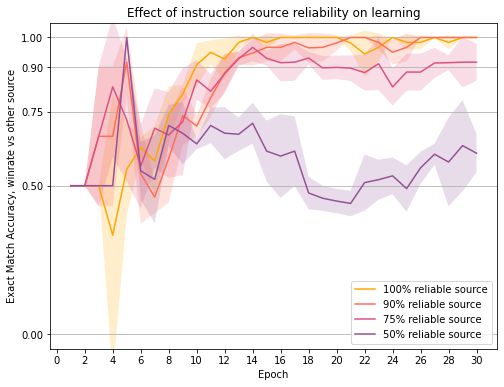

In [ ]:
for data_path, epochs, mean_accuracy, std_accuracy in plot_data:
    reliability = get_reliability_from_datapath(data_path)
    label = f"{reliability}% reliable source"

    plt.plot(epochs, mean_accuracy, label=label)
    plt.fill_between(epochs, mean_accuracy-std_accuracy, mean_accuracy+std_accuracy, alpha=0.2)


# Show the plot
plt.grid(axis='y')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15+1))

plt.title('Effect of instruction source reliability on learning')
plt.xlabel('Epoch')
plt.ylabel('Exact Match Accuracy, winrate vs other source')
plt.legend(loc='lower right')

plt.yticks([0.0, 0.5, 0.75, 0.9, 1.0])
plt.ylim(-0.05, 1.05)
plt.savefig(f'winrate_{experiment_name}.png', dpi=300)
plt.savefig(f'winrate_{experiment_name}.pdf', dpi=300)

# make it bigger
plt.gcf().set_size_inches(8, 6)

### Weighted Accuracy

In [ ]:
# 4. Make data for the plot
plot_data = []
for data_path, runs in runs_by_path.items():

    # Collect epoch and accuracy data across runs for the same data path
    accuracies_by_epoch = defaultdict(list)
    for run in runs:
        num_epochs = run.config.get('num_epochs')
        metric_key = 'eval/mean/weighted_accuracy'

        if metric_key not in run.summary:
            continue

        history = run.scan_history(keys=[metric_key])
        for i, row in enumerate(history):
            epoch_num = i+1 # assume logged once per epoch
            accuracies_by_epoch[epoch_num].append(row[metric_key])

        assert len(accuracies_by_epoch) == num_epochs, f"num_epochs: {num_epochs}, len(accuracies_by_epoch): {len(accuracies_by_epoch)}"

    # Convert to numpy arrays for easier manipulation
    epochs = np.array(list(accuracies_by_epoch.keys()))
    accuracies = np.array(list(accuracies_by_epoch.values()))

    # Calculate mean and standard deviation
    mean_accuracy = np.mean(accuracies, axis=1)
    std_accuracy = np.std(accuracies, axis=1)

    # Plot mean accuracy and standard deviation
    plot_data.append((data_path, epochs, mean_accuracy, std_accuracy))

plot_data.sort(key=lambda x: get_reliability_from_datapath(x[0]), reverse=True)

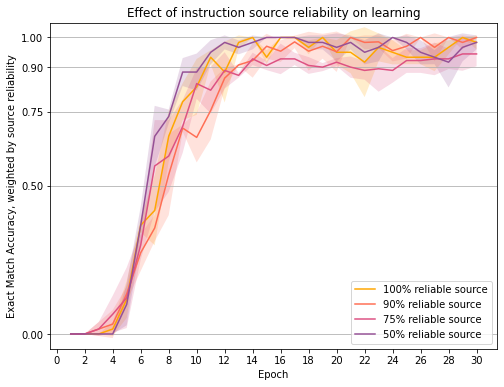

In [ ]:
for data_path, epochs, mean_accuracy, std_accuracy in plot_data:
    reliability = get_reliability_from_datapath(data_path)
    label = f"{reliability}% reliable source"

    plt.plot(epochs, mean_accuracy, label=label)
    plt.fill_between(epochs, mean_accuracy-std_accuracy, mean_accuracy+std_accuracy, alpha=0.2)


# Show the plot
plt.grid(axis='y')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15+1))

plt.title('Effect of instruction source reliability on learning')
plt.xlabel('Epoch')
plt.ylabel('Exact Match Accuracy, weighted by source reliability')
plt.legend(loc='lower right')

plt.yticks([0.0, 0.5, 0.75, 0.9, 1.0])
plt.ylim(-0.05, 1.05)
plt.savefig(f'weighted_accuracy_{experiment_name}.png', dpi=300)
plt.savefig(f'weighted_accuracy_{experiment_name}.pdf', dpi=300)

# make it bigger
plt.gcf().set_size_inches(8, 6)